<font size="5">
 <div class="alert alert-block alert-info"> <b> Objetivo 3 - Modelo Hibrido | milk manufacturing price producer <b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  

    
  <font size="3">ISCTE-IUL </font>
     



<font size="4"> **Agenda** </font>  
  
- Imports and Defines
  - Imports
  - Define Function
- Define Univariate Time-Series
- Stationarity of the Time-Series
  - Data transformation and its graphical representation
  - Normality tests
  - Unit Root and Stationarity Tests
- ARIMA Selection
  - Pre-processing
  - Model training
  - Model Comparison based on Information Criteria
  - Selected Models Information Criteria Comparison
  - Model Prediction Overview
- Model Selection and Validation
  - Model Residual Analysis
  - Normality Test
  - Test for No Autocorrelation


# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary for this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this work (https://github.com/DidierRLopes/TimeSeriesCrossValidation)

In [199]:
# See:
# https://github.com/DidierRLopes/timeseries-cv/blob/master/README.md

# Read the story's origin: 
# https://dro-lopes.medium.com/time-series-crossvalidation-for-nn-6279cd5ae25e


#!pip install timeseries-cv

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#from TimeSeriesCrossValidation import splitTrain
from matplotlib.lines import Line2D
from collections import OrderedDict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, bds
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## Define Functions
    Defines helper functions

In [2]:
# Parse string into tuple
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return

In [3]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [4]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [5]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [6]:
# Evaluate combinations of p, d and q values for an ARIMA model
def ARIMA_grid(dataset, arimaCfg, isLog, stepsToForecast):
    df_IC = pd.DataFrame(columns=['ARIMA(p, d, q)', 'AIC', 'BIC', 'HQIC'])
    df_IC.set_index('ARIMA(p, d, q)', inplace=True)
    dict_arimaFit = {}
    dict_arimaPred = {}
    modelNum = 0
    totalModelNum = len(arimaCfg.p_range) * len(arimaCfg.d_range) * len(arimaCfg.q_range)

    for p in arimaCfg.p_range:
        for d in arimaCfg.d_range:
            for q in arimaCfg.q_range:
                order = (p, d, q)
                modelNum += 1
                print(f"{modelNum}/{totalModelNum}")

                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()

                    # Check if the model is fitted successfully
                    model_str = f'ARIMA{order}'
                    df_IC = pd.concat([df_IC, pd.DataFrame({
                        'AIC': model_fit.aic,
                        'BIC': model_fit.bic,
                        'HQIC': model_fit.hqic
                    }, index=[model_str])])

                    if isLog:
                        dict_arimaFit[model_str] = np.e ** (model_fit.predict(typ='levels'))
                        dict_arimaPred[model_str] = np.e ** (model_fit.forecast(steps=stepsToForecast[-1]))
                    else:
                        dict_arimaFit[model_str] = model_fit.predict(typ='levels')
                        dict_arimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1])

                except Exception as e:
                    print(f"Error fitting ARIMA{order}: {e}")
                    continue

    return dict_arimaFit, dict_arimaPred, df_IC

## Define Univariate Time-Series
    df: Dataframe with an index and a value column
    title: Title of data being used
    serie: Serie 'Name'
    xlab: Label of df.index
    ylab: Label of df.values
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [7]:
previousStepsToShow = 15;

#TIME SERIES WITH TREND

stepsToForecast = [1, 3, 12]

df = pd.read_csv("../data/data_milk_manufacturing_price_producer.csv")
df = df.rename(columns={'observation_date': 'Date', 'PCU3115113115111': 'Value'})
df = df.dropna()
df.set_index('Date', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.truncate(before='1995-01', after='2023-03')

title = 'Producer Price Index by Industry: Fluid Milk Manufacturing: Fluid Milk and Cream, Bulk Sales'
serie = "Producer Price Index"
xlab = 'Months/Year';
ylab = 'U.S. Dollars';

df_train = df[['Value']][:-stepsToForecast[-1]].rename(columns={'Value': 'train'})
df_test = df[['Value']][-stepsToForecast[-1]:].rename(columns={'Value': 'test'})

# Stationarity of the Time-Series

## Data transformation and its graphical representation
    This section allows to understand the representation of the series after its transformation to achieve stationarity

    Box-Cox transformations such as the logarithmic one can help to stabilise the variance of a time series. 
    Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.
    Note: The order Box-Cox transformation, and then, differencing, is important!

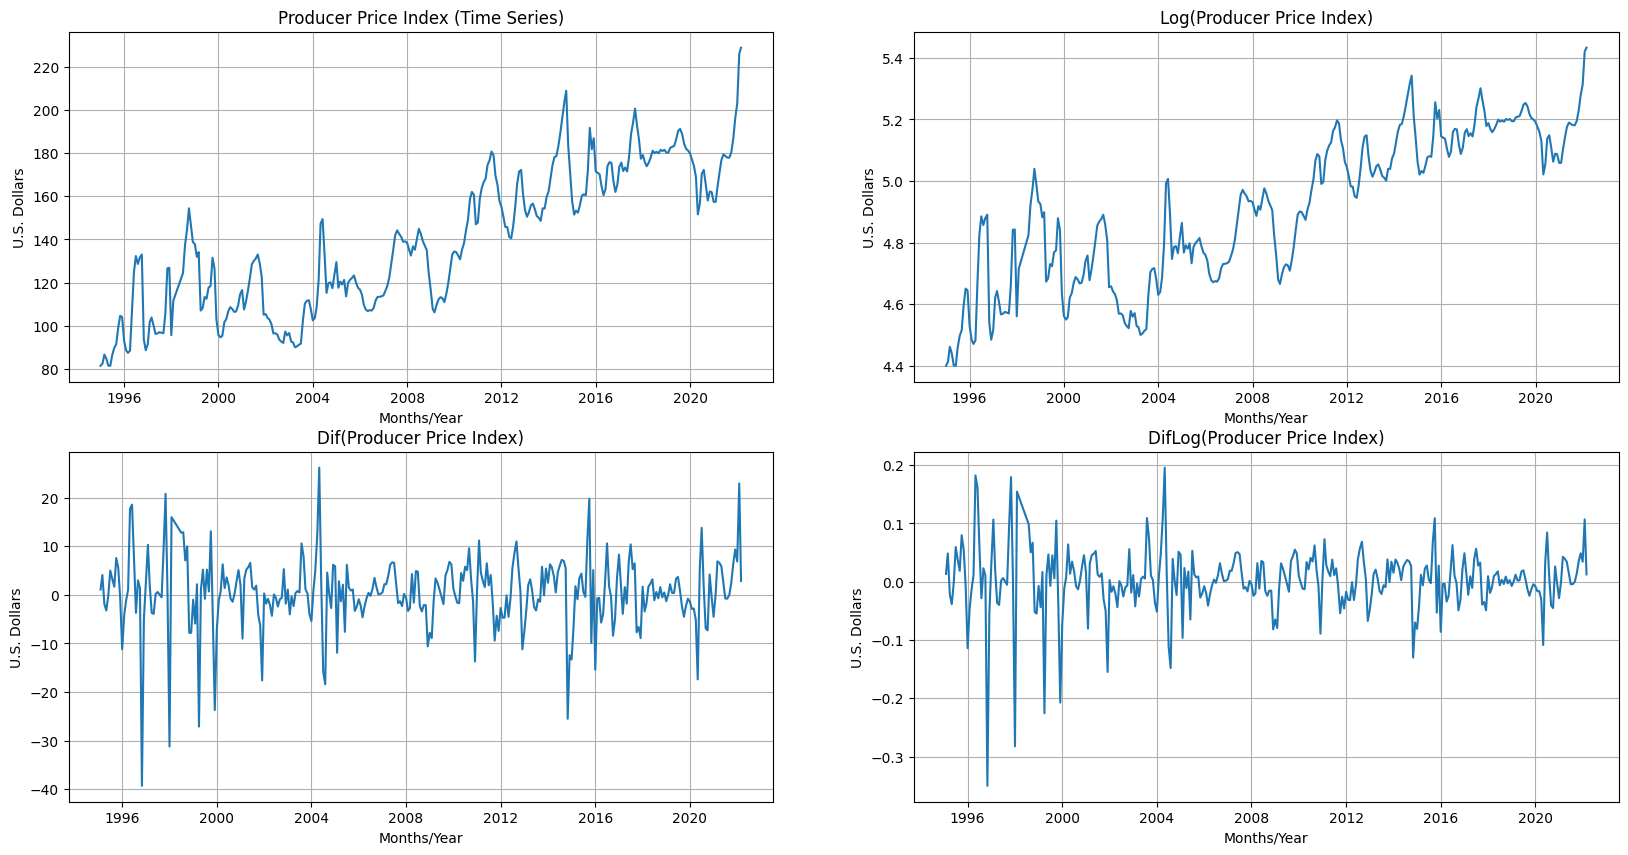

In [8]:
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(serie + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + serie + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + serie + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + serie + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

## Normality tests

### Jarque-Bera test
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [9]:
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + serie + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + serie + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 

Jarque-Bera Test for Producer Price Index
Statistic: 15.0443
p-value: 0.0005

Jarque-Bera Test for Log(Producer Price Index)
Statistic: 16.8704
p-value: 0.0002

Jarque-Bera Test for Diff(Producer Price Index)
Statistic: 483.9502
p-value: 0.0000

Jarque-Bera Test for Diff(Log(Producer Price Index))
Statistic: 1163.3440
p-value: 0.0000


### Kolmogorov-Smirnov test
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either 'two-sided' (default), 'less' or 'greater'. The KS test is only valid for continuous distributions.

In [10]:
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test for " + serie)
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + serie + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + serie + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kolmogorov-Smirnov Test for Producer Price Index
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(Producer Price Index)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Producer Price Index)
Statistic: 0.3689
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(Producer Price Index))
Statistic: 0.4407
p-value: 0.0000


## Unit Root and Stationarity Tests

### The Augmented Dickey-Fuller test 
    Augmented Dickey-Fuller unit root test.
    The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [11]:
result = adfuller(df_train['train'].values, regression='c')
print("Augmented Dickey Fuller Test for " + serie)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values), regression='c')
print("Augmented Dickey Fuller Test for Log(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna(), regression='c')
print("Augmented Dickey Fuller Test for Diff(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values, regression='c')
print("Augmented Dickey Fuller Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for Producer Price Index
Statistic: -1.6975
p-value: 0.4324
Used lags: 3
Num obs: 318
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572

Augmented Dickey Fuller Test for Log(Producer Price Index)
Statistic: -1.7749
p-value: 0.3930
Used lags: 7
Num obs: 314
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572

Augmented Dickey Fuller Test for Diff(Producer Price Index)
Statistic: -7.2292
p-value: 0.0000
Used lags: 6
Num obs: 314
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572

Augmented Dickey Fuller Test for Diff(Log(Producer Price Index))
Statistic: -7.5090
p-value: 0.0000
Used lags: 6
Num obs: 314
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


### Kwiatkowski-Phillips-Schmidt-Shin test
    Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
    Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

In [12]:
result = kpss(df_train['train'].values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values), regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Log(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna(), regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

Kwiatkowski-Phillips-Schmidt-Shin Test for Producer Price Index
Statistic: 2.6758
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Log(Producer Price Index)
Statistic: 2.6421
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(Producer Price Index)
Statistic: 0.0360
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(Log(Producer Price Index))
Statistic: 0.0256
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


## Correlation plots
    These plots are useful for identifying non-stationary time series 

    This also gives an idea of the order of the model by:
        AR(p) - p from the partial autocorrelation plot
        I(d)  - d from the number of Diffs your dataset is using
        MA(q) - q from the autocorrelation plot

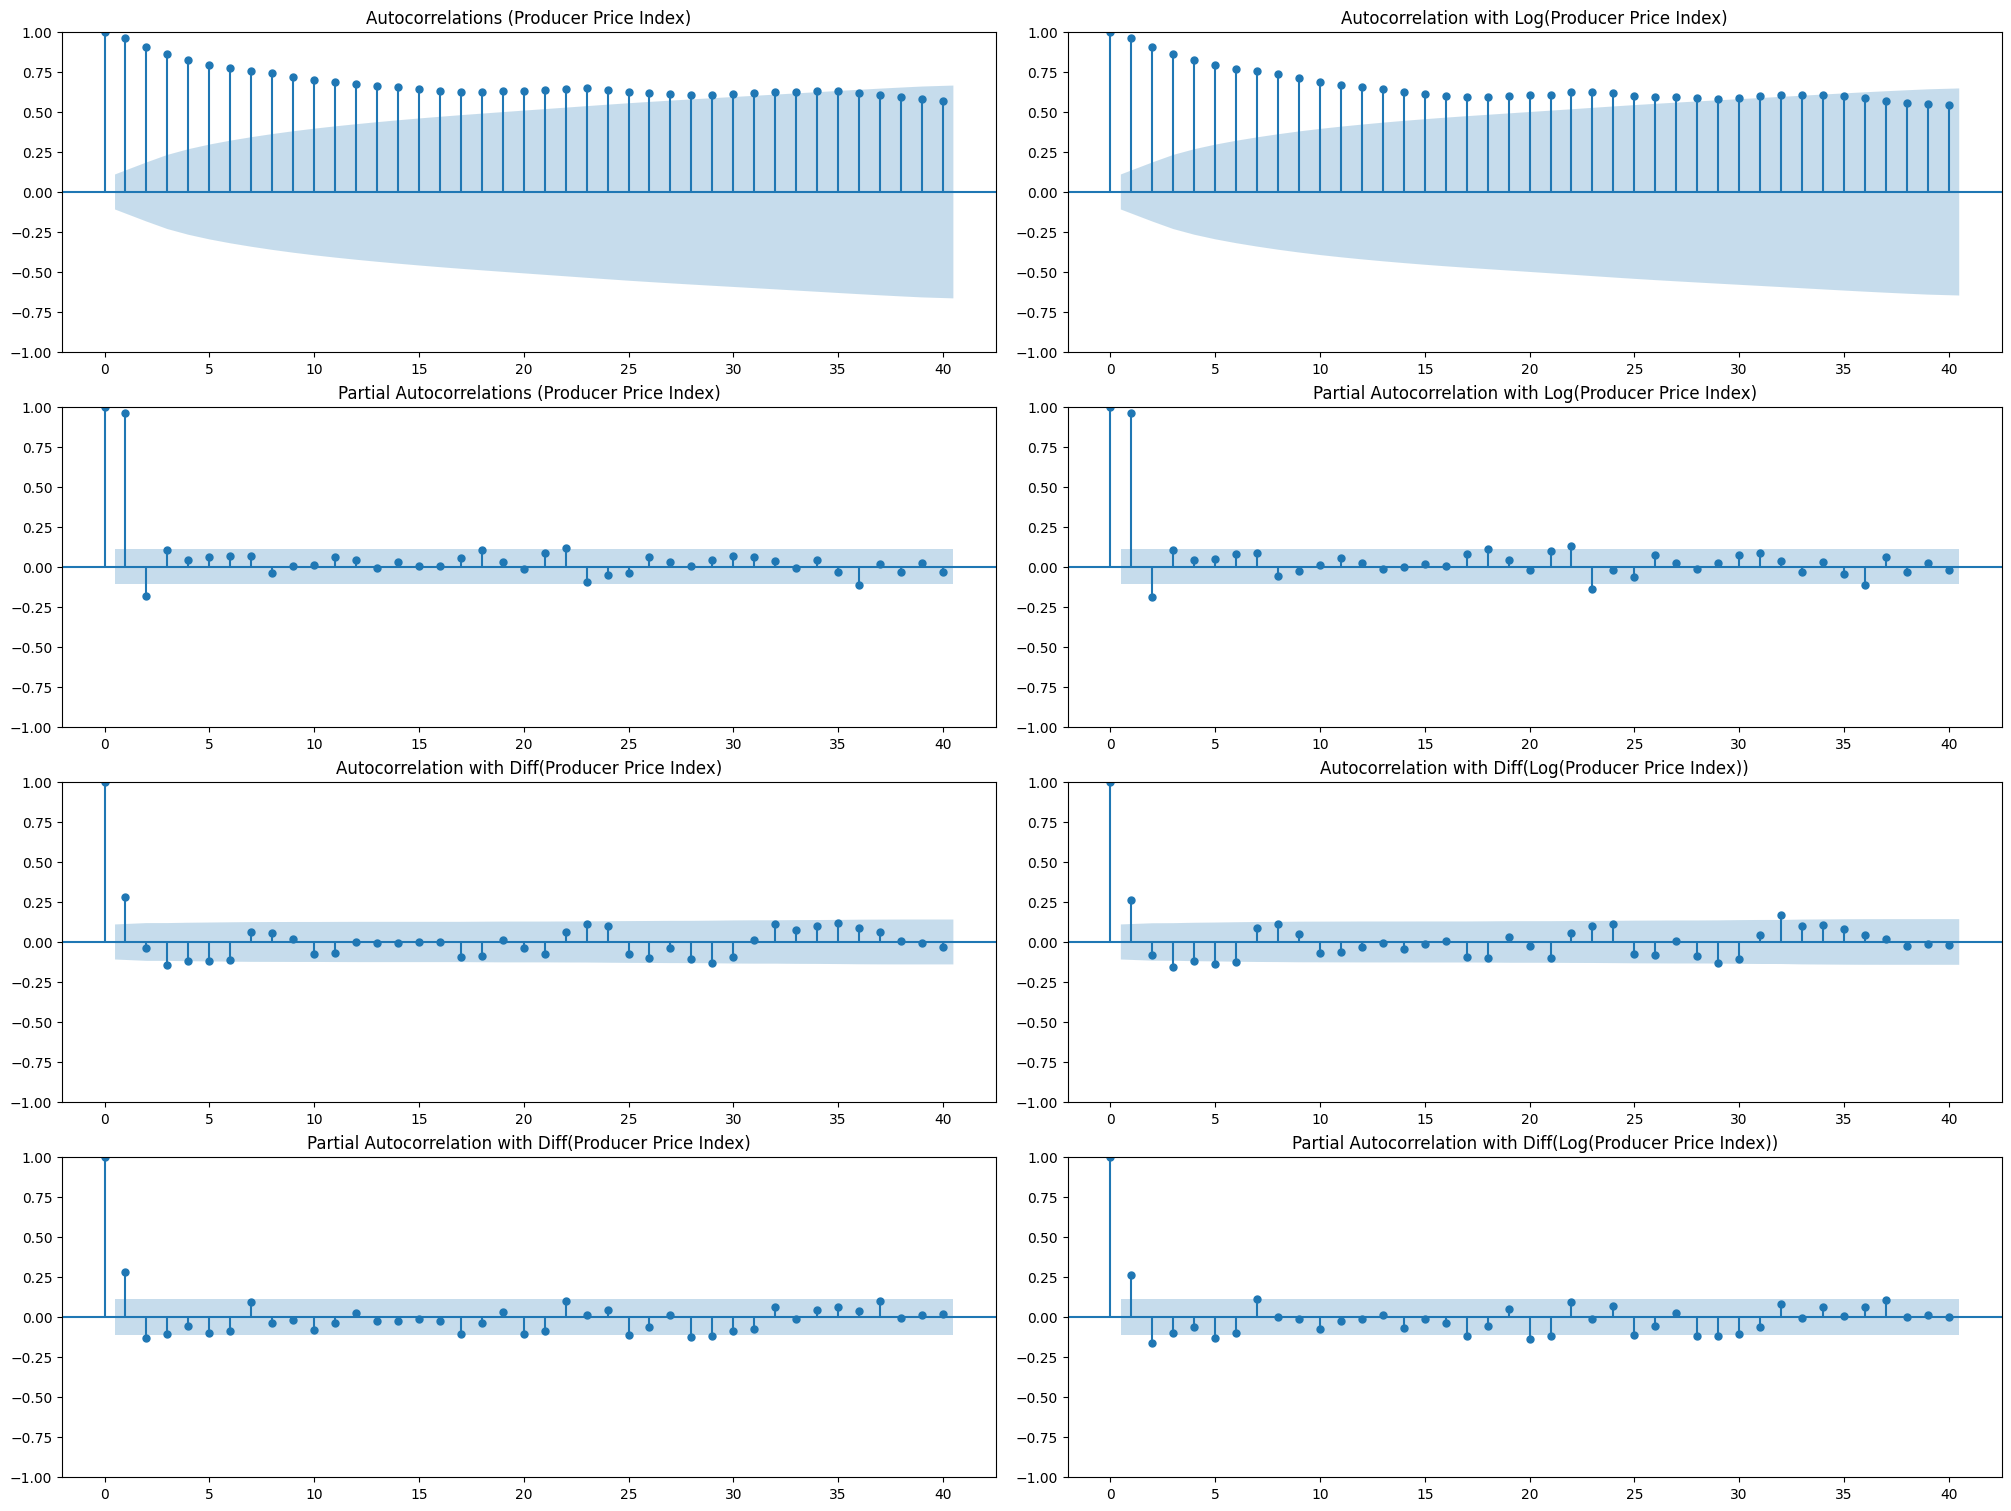

In [13]:
maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + serie + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ serie + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ serie + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ serie + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ serie + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ serie + '))');

plt.show()

# ARIMA Selection

## Pre-processing
    From now on, we must choose whether we go with the Log(Time-Series) or not. This should be done to remove stationarity of the data, so that ARIMA can work. In addition, if the model is multiplicative we need to use log to make it additive as ARIMA relies on that assumption. The previously seen differentiated data enters in the I component of the ARIMA model it will take care of differenciating for us.

In [14]:
isLog = True

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()

## Model training
    In this section we will train several ARIMA models based on distinct (p,d,q) combinations.
    Not only train but also forecast, and extract their AIC, BIC and HQIC.

In [15]:
# Range of ARIMA models to compute
class arimaCfg:
    p_range = range(1, 5) # [1,7)
    d_range = range(1, 2) # [1,3)
    q_range = range(1, 4) # [1,7)

dict_arimaFit, dict_arimaPred, df_IC = ARIMA_grid(df_Train.values, arimaCfg, isLog, stepsToForecast)
#dict_arimaFit, dict_arimaPred, df_IC

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


## Model Comparison based on Information Criteria
    AIC - Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data.
    BIC - Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It is based, in part, on the likelihood function and it is closely related to AIC.
    HQIC - Hannan–Quinn information criterion (HQIC) is a criterion for model selection. It is an alternative to AIC and BIC.

In [16]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                 TOP 5 AIC
ARIMA(2, 1, 1) -981.193651
ARIMA(1, 1, 3) -980.871555
ARIMA(3, 1, 1) -980.570834
ARIMA(2, 1, 2) -980.322620
ARIMA(1, 1, 2) -980.230020
 
                 TOP 5 BIC
ARIMA(2, 1, 1) -966.107886
ARIMA(1, 1, 2) -965.144256
ARIMA(1, 1, 3) -962.014349
ARIMA(3, 1, 1) -961.713628
ARIMA(2, 1, 2) -961.465414
 
                TOP 5 HQIC
ARIMA(2, 1, 1) -975.170276
ARIMA(1, 1, 2) -974.206646
ARIMA(1, 1, 3) -973.342337
ARIMA(3, 1, 1) -973.041616
ARIMA(2, 1, 2) -972.793402


## Selected Models Information Criteria Comparison
    Evaluate models based on their Information Criteria (IC)

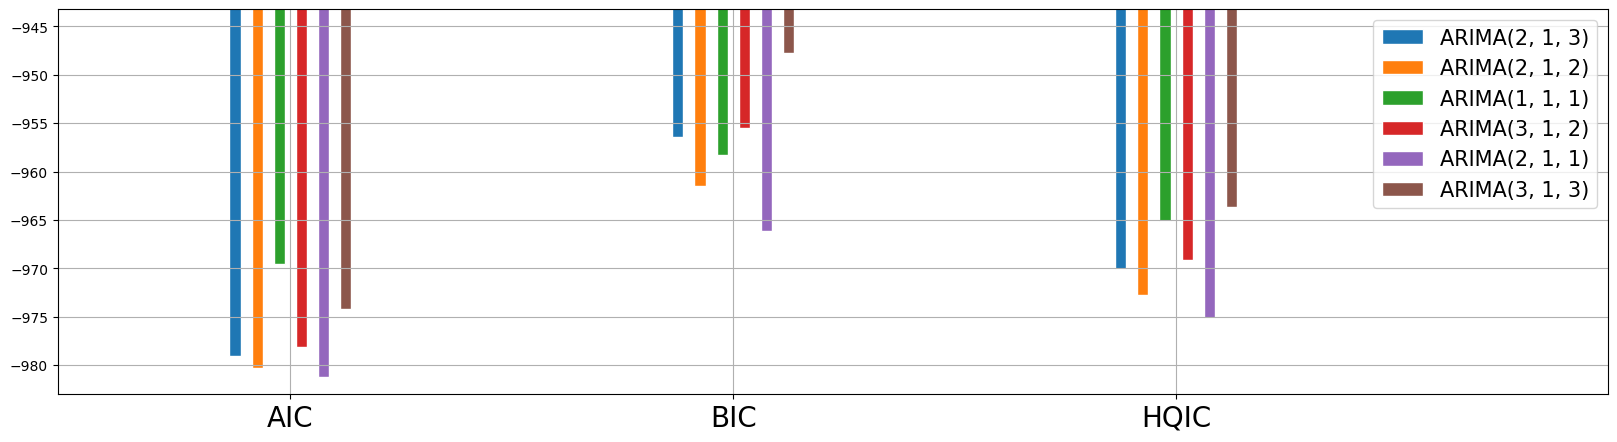

In [17]:
labels = ['ARIMA(2, 1, 3)',
          'ARIMA(2, 1, 2)',
          'ARIMA(1, 1, 1)',
          'ARIMA(3, 1, 2)',
          'ARIMA(2, 1, 1)',
          'ARIMA(3, 1, 3)']


plt.figure(figsize=(20,5))
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

## Model Prediction Overview
    Compare: Fitted values of the model with the training data
             Predicted values of the model with the testing data
      
    This section allows to see the forecast of the model that was selected and validated, but also to compare it against other models.

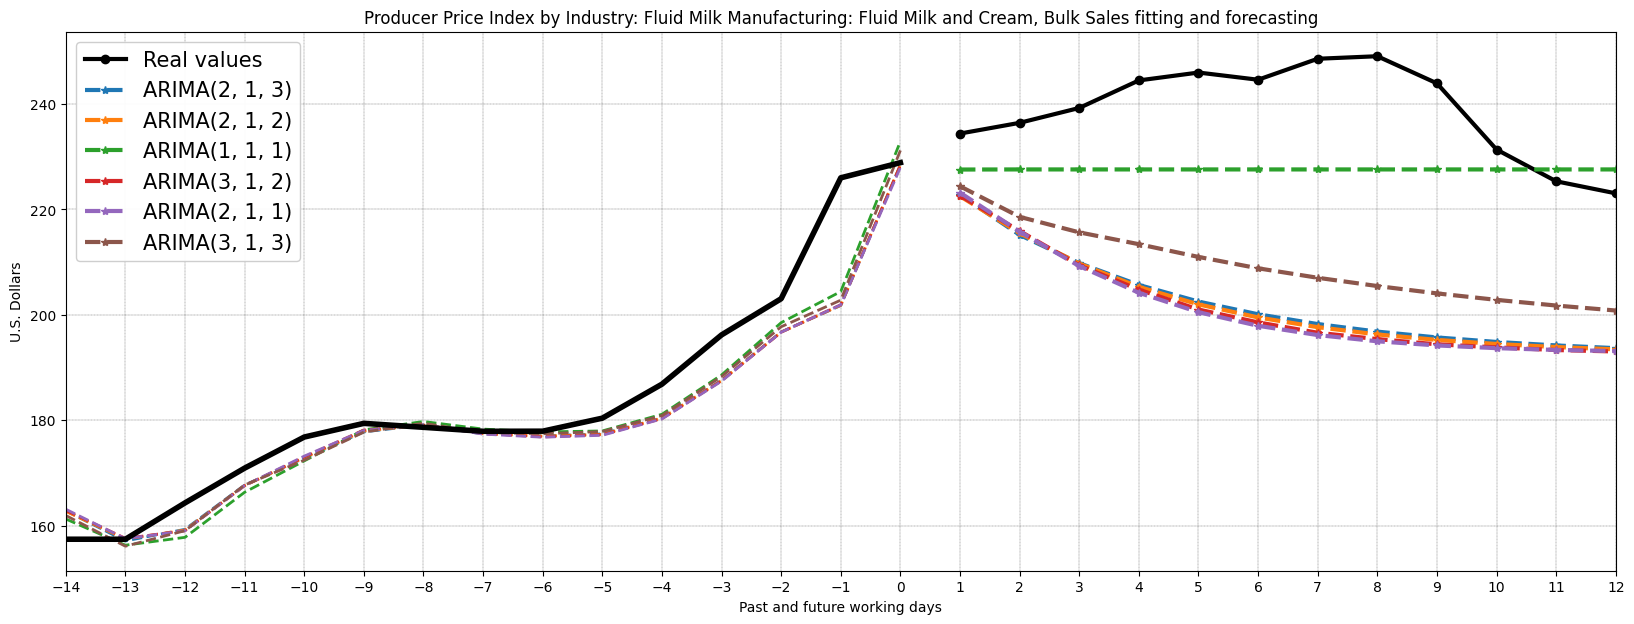

ARIMA(2, 1, 3)
Prediction for 1 Months/Year: MAE = 11.62 (4.96%)
Prediction for 3 Months/Year: MAE = 20.79 (8.76%)
Prediction for 12 Months/Year: MAE = 36.43 (15.15%)

ARIMA(2, 1, 2)
Prediction for 1 Months/Year: MAE = 11.89 (5.07%)
Prediction for 3 Months/Year: MAE = 20.79 (8.76%)
Prediction for 12 Months/Year: MAE = 36.77 (15.29%)

ARIMA(1, 1, 1)
Prediction for 1 Months/Year: MAE = 6.83 (2.91%)
Prediction for 3 Months/Year: MAE = 9.12 (3.84%)
Prediction for 12 Months/Year: MAE = 12.42 (5.11%)

ARIMA(3, 1, 2)
Prediction for 1 Months/Year: MAE = 11.78 (5.02%)
Prediction for 3 Months/Year: MAE = 20.73 (8.73%)
Prediction for 12 Months/Year: MAE = 37.32 (15.52%)

ARIMA(2, 1, 1)
Prediction for 1 Months/Year: MAE = 11.22 (4.79%)
Prediction for 3 Months/Year: MAE = 20.63 (8.69%)
Prediction for 12 Months/Year: MAE = 37.53 (15.61%)

ARIMA(3, 1, 3)
Prediction for 1 Months/Year: MAE = 10.01 (4.27%)
Prediction for 3 Months/Year: MAE = 17.16 (7.23%)
Prediction for 12 Months/Year: MAE = 29.4 (12.22

In [18]:
labels = ['Real Closing price',
          'ARIMA(2, 1, 3)',
          'ARIMA(2, 1, 2)',
          'ARIMA(1, 1, 1)',
          'ARIMA(3, 1, 2)',
          'ARIMA(2, 1, 1)',
          'ARIMA(3, 1, 3)']


plt.figure(figsize=(20,7))
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o', linewidth = 3, label='Real values')
for i in np.arange(len(labels)-1):
    arimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=arimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 ) # label = labels[i+1]  legenda
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")

# Model Selection and Validation
    This section allows to validate the selected model

In [19]:
# Pick you favourite's models order
order = (1, 1, 1)

model = ARIMA(df_Train.values, order=order)
model_fit = model.fit()
residuals = model_fit.resid
start_idx = len(df_Train) - len(residuals)
df_res = pd.DataFrame({"resid": residuals}, index = df_Train.index[start_idx:])
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 487.793
Date:                Sat, 24 May 2025   AIC                           -969.586
Time:                        19:59:05   BIC                           -958.272
Sample:                             0   HQIC                          -965.068
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.150     -0.097      0.923      -0.309       0.280
ma.L1          0.3160      0.150      2.111      0.035       0.023       0.609
sigma2         0.0028   9.83e-05     28.500      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1553.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Residual Analysis
    Plots residual and its histogram

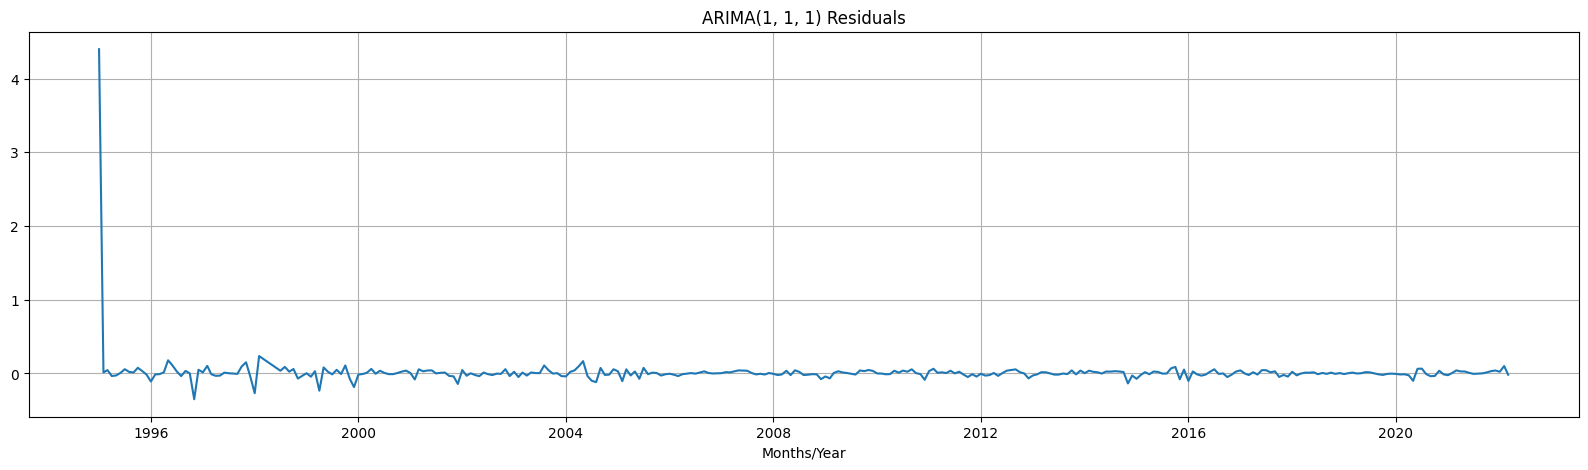

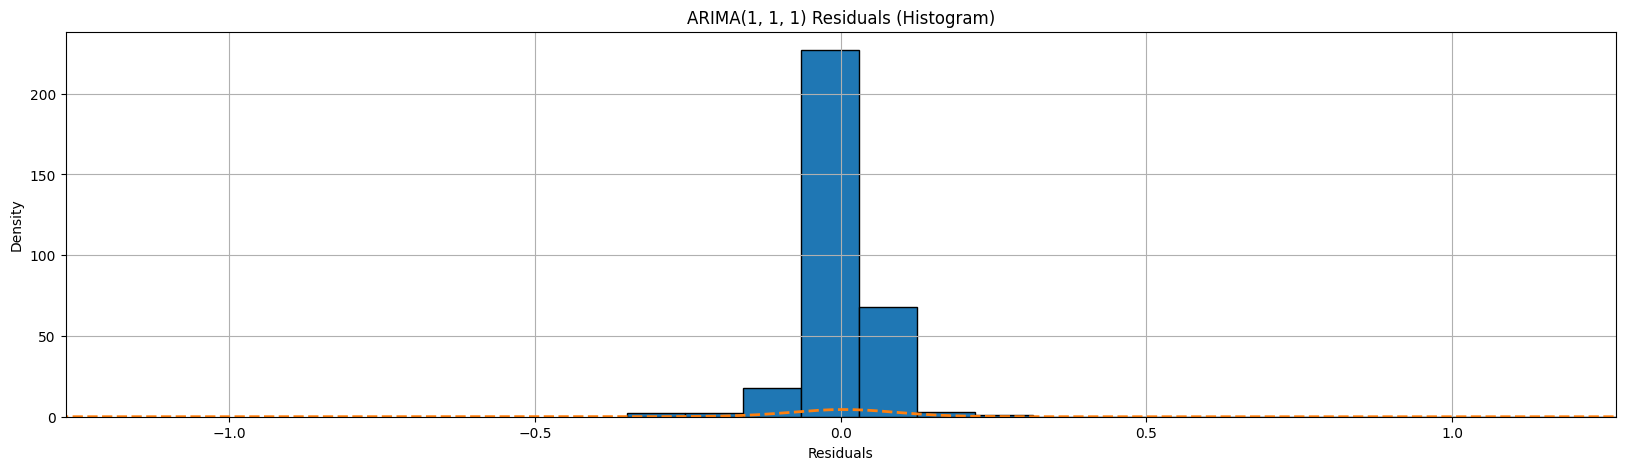

Mean: 0.016126
Variance: 0.062641


In [20]:
# Plot model residual
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('ARIMA' + str(order) +' Residuals')
plt.grid()
plt.show()

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('ARIMA' + str(order) + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, edgecolor='black')
df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

## Normality Test

### Kurtosis and Kurtosis Test
    Compute the kurtosis (Fisher or Pearson) of a dataset.
    Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

    Test whether a dataset has normal kurtosis.
    This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [21]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

Kurtosis Test
Statistic: 13.6278
p-value: 0.0000
Kurtosis value: 289.1877


### Skew and Skewness Test
    Compute the skewness of a data set.
    For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function `skewtest` can be used to determine if the skewness value is close enough to 0, statistically speaking.

    Test whether the skew is different from the normal distribution.
    This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [22]:
s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test for")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 

Skew Test for
Statistic: 23.2504
p-value: 0.0000
Skewness value: 16.6620


### Jarque-Bera and Kolmogorov-Smirnov tests
    Tests for goodness of fit (previously mentioned)

In [23]:
jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

print(" ")

ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Jarque-Bera Test
Statistic: 1136928.1328
p-value: 0.0000
 
Kolmogorov-Smirnov Test
Statistic: 0.4414
p-value: 0.0000


### Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [24]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print("Lagrange multiplier Test")
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)

Lagrange multiplier Test
LM Statistic: 14.9366
LM-Test p-value: 0.1344

fstatistic for F test
F Statistic: 1.5135
F-Test p-value: 0.1335


## Test for No Autocorrelation

### Brock–Dechert–Scheinkman test
    Calculate the BDS test statistic for independence of a time series

In [25]:
result = bds(df_res['resid'].values, max_dim=6);
print("Brock Dechert and Scheinkman Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

Brock Dechert and Scheinkman Test
Dim 2: z-static -17.0502 Prob 0.0000
Dim 3: z-static -7.6581 Prob 0.0000
Dim 4: z-static -4.6568 Prob 0.0000
Dim 5: z-static -3.1986 Prob 0.0014
Dim 6: z-static -2.3616 Prob 0.0182


### Breusch-Godfrey test
    Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation

In [26]:
lm, lmpval, fval, fpval = acorr_breusch_godfrey(model_fit, nlags = max(order[0], order[2]))
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)

Lagrange multiplier test statistic
LM Statistic: 0.0005
LM-Test p-value: 0.9825

fstatistic for F test
F Statistic: 0.0005
F-Test p-value: 0.9826


### Box-Pierce and Ljung-Box tests
    Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is reported to have better small sample properties.

In [27]:
maxLags = 21
results_acorr_ljungbox = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)
results_acorr_ljungbox.rename(columns={"lb_stat":"Ljung-Box stats", "lb_pvalue":"Ljung-Box p-value", "bp_stat":"Box-Pierce stats", "bp_pvalue":"Box-Pierce p-value"}, inplace=True)
results_acorr_ljungbox

,Ljung-Box stats,Ljung-Box p-value,Box-Pierce stats,Box-Pierce p-value
1,0.001696,0.967146,0.001681,0.967298
2,0.020043,0.990029,0.019801,0.990149
3,0.084612,0.993618,0.083373,0.993755
4,0.112703,0.998471,0.110944,0.998517
5,0.115256,0.999770,0.113442,0.999779
6,0.128035,0.999958,0.125906,0.999960
7,0.152018,0.999990,0.149222,0.999991
8,0.162202,0.999998,0.159092,0.999998
9,0.274072,0.999998,0.267163,0.999998
10,0.278078,1.000000,0.271022,1.000000


### QQplot
    Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
    Can take arguments specifying the parameters for dist or fit them automatically.

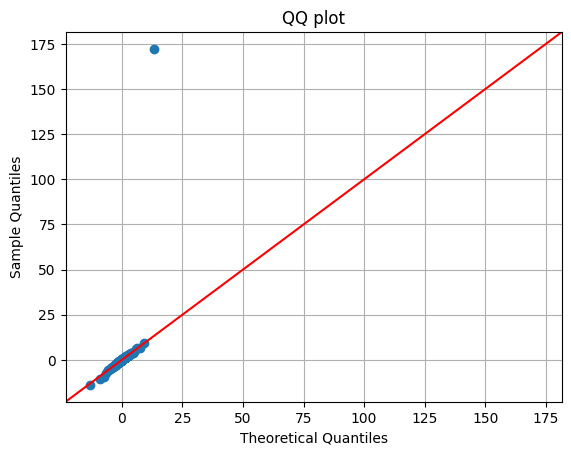

In [28]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

### Plot Auto-correlation and Partial Auto-correlation functions
    Plots lags on the horizontal and the correlations on vertical axis.

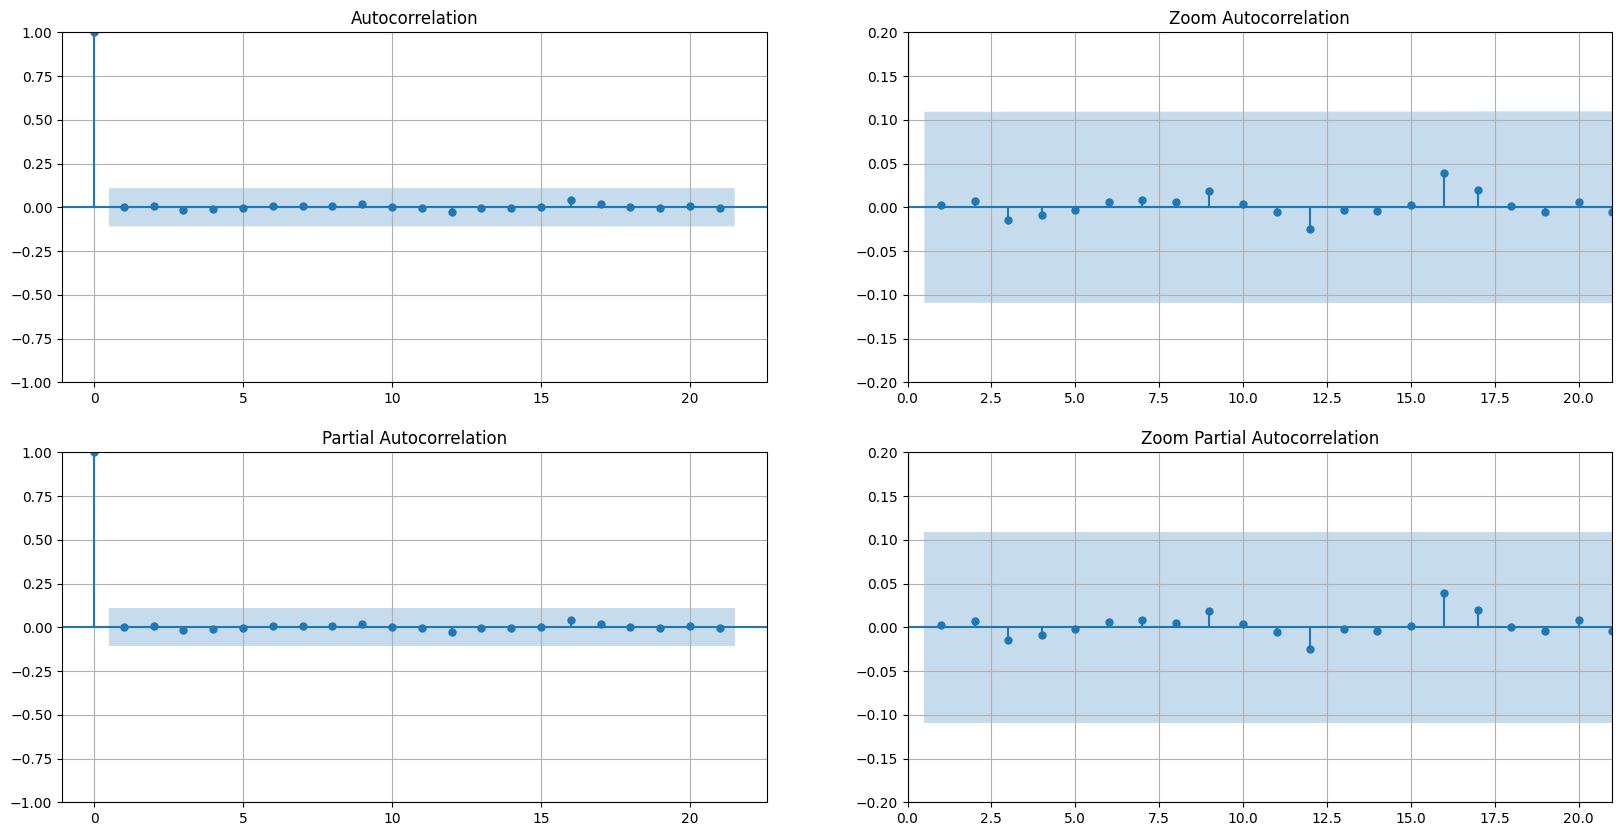

In [29]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

In [30]:
# Forecasted values of ARIMA model

dict_arimaPred['ARIMA' + str(order)]


array([227.58654347, 227.60545831, 227.60518347, 227.60518746,
       227.6051874 , 227.6051874 , 227.6051874 , 227.6051874 ,
       227.6051874 , 227.6051874 , 227.6051874 , 227.6051874 ])